In [1]:
%matplotlib inline

import numpy as np  # linear algebra
import os
import sys
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import ct_utils

# Some constants
INPUT_FOLDER = '/media/gaetano/My Passport/Dicom_DATA/'
# INPUT_FOLDER = '/home/gaetano/Desktop/DATA/'
# path_to_sample = os.listdir(INPUT_FOLDER)
# path_to_sample.sort()

In [2]:
paths_to_samples = []
found_count = 1
total_count = 1
for root, dir, filelist in os.walk(INPUT_FOLDER, topdown=True):
    for name in dir:
        if name == 'THIN_ST_HEAD':
            paths_to_samples.append(os.path.join(root, name + '/'))
            print(f'Found Count: {found_count} / {total_count}', end="\r")
            found_count += 1
        total_count += 1

In [3]:
# first_sample = ct_utils.load_scan(INPUT_FOLDER + paths_to_samples[1])
first_sample = ct_utils.load_scan(paths_to_samples[1])
first_sample_pixels = ct_utils.get_pixels_hu(first_sample)

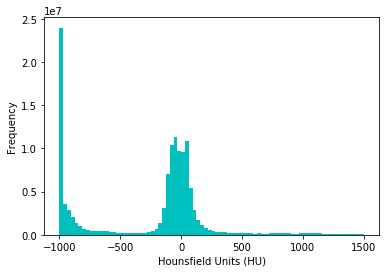

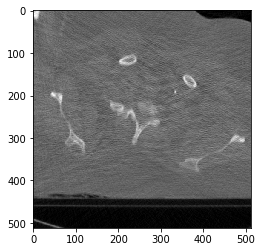

In [4]:
# Show histogram of Hounsfield density bins
plt.hist(first_sample_pixels.flatten(), bins=80, range=(-1000, 1500) ,color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_sample_pixels[80], cmap=plt.cm.gray)
plt.show()

In [5]:
# Resample volume

pix_resampled, spacing = ct_utils.resample(first_sample_pixels, first_sample, [1, 1, 1])
print("Shape before resampling\t", first_sample_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (577, 512, 512)
Shape after resampling	 (288, 290, 290)


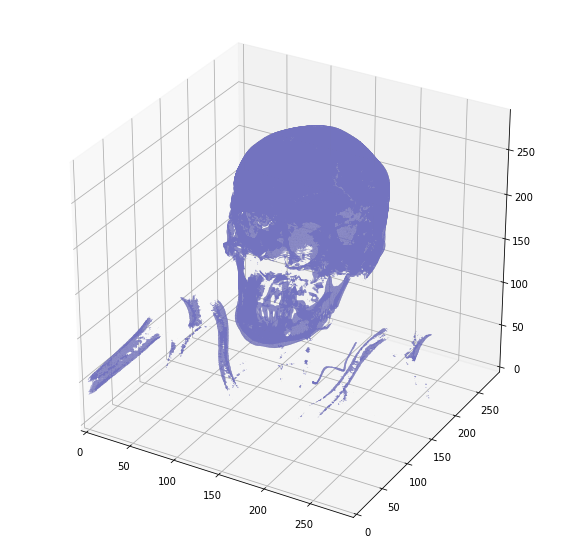

In [6]:
ct_utils.plot_3d(pix_resampled, 1200)

In [7]:
# vv = visualize_volumes.ImageSliceViewer3D(pix_resampled)
ct_utils.make_gifs(pix_resampled, "test_gif", "axial")

		done with axial gif


![SegmentLocal](test_gif_axial.gif "segment")

In [8]:
def jaw_segmenter(volume, hu_threshold=(1600, 2000), iterations=2, cut_off=1.5, growth_rate=1):
    hu_min = hu_threshold[0]
    hu_max = hu_threshold[1]
    filtered_image = ct_utils.filter_bounds(volume, hu_min, hu_max)
    binary_image = ct_utils.binarize(filtered_image)
    non_zero_coords = np.array(list(zip(*map(list, binary_image.nonzero()))))
    distance_mat = distance_matrix([non_zero_coords.mean(axis=0)], non_zero_coords)
    std_dev = np.mean(distance_mat)
    args_to_keep = np.argwhere(distance_mat[0]<std_dev * cut_off)
    bounding_coords = non_zero_coords[args_to_keep]
    max_box = np.amax(bounding_coords, axis=0)[0]
    min_box = np.amin(bounding_coords, axis=0)[0]
    jaw_isolated = pix_resampled[min_box[0]:max_box[0], min_box[1]:max_box[1], min_box[2]:max_box[2]]
    return jaw_isolated

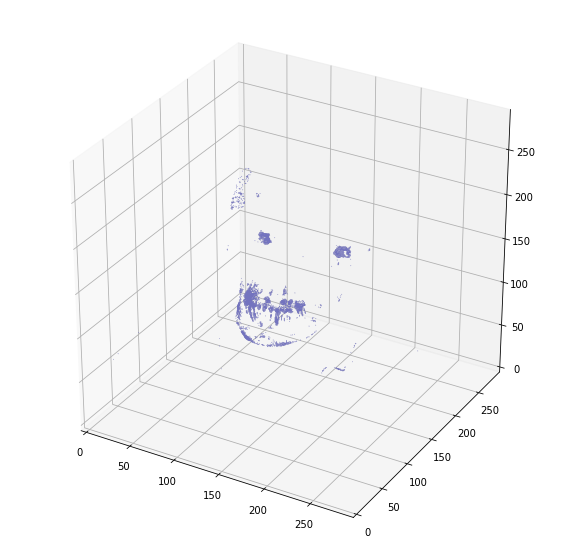

In [9]:
filtered_image = ct_utils.filter_bounds(pix_resampled, 1600, 2000)
ct_utils.plot_3d(filtered_image)

In [10]:
filtered_image.shape

binary_image = ct_utils.binarize(filtered_image)
non_zero_coords = np.array(list(zip(*map(list, binary_image.nonzero()))))

np.mean(non_zero_coords, axis=0)
np.std(non_zero_coords, axis=0)

array([25.83257472, 41.10587392, 28.77281217])

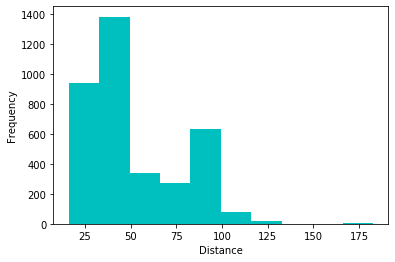

50.71293323444628


In [11]:
distance_mat = distance_matrix([non_zero_coords.mean(axis=0)], non_zero_coords)

plt.hist(distance_mat[0] ,color='c')
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()
print(np.mean(distance_mat))

In [12]:
std_dev = np.mean(distance_mat)
args_to_keep = np.argwhere(distance_mat[0]<std_dev * 1.5)
bounding_coords = non_zero_coords[args_to_keep]
max_box = np.amax(bounding_coords, axis=0)[0]
min_box = np.amin(bounding_coords, axis=0)[0]
jaw_isolated = pix_resampled[min_box[0]:max_box[0], min_box[1]:max_box[1], min_box[2]:max_box[2]]

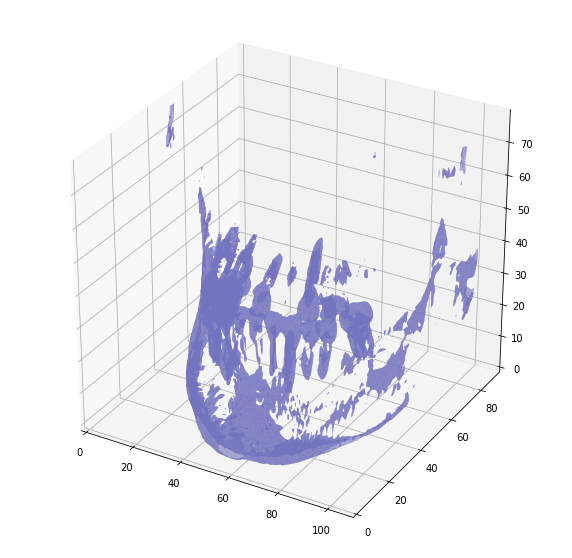

In [13]:
# %matplotlib widget
ct_utils.plot_3d(jaw_isolated, 1500)

In [14]:
# Normalize the image between selected HU units

MIN_BOUND = 1600.0
MAX_BOUND = 1800.0

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [15]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image